# 実践的な分析
- 実務で使えそうな統計的な手法や分析方法についてまとめる
- 実際の実務で本ノートブックを見れば使える状態を目指す
- 記述統計や検定の基本的な考え方などについては省略

## 目次
1. 比率の差の検定
2. 平均値差の検定
3. 検定力分析
4. データ間の関係性に関する分析
    - カイ二乗検定
    - アソシエーション分析
    - 数量化理論
5. クラスタリング
6. 回帰分析

## 準備

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.api import qqplot
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
# データセットダウンロード
df = sns.load_dataset('tips')
# チップ率というカラムを追加
df['tip_rate'] = df["tip"] / df["total_bill"]
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


## 検定を行う前の目的確認
そもそも、検定を行う目的とは？  
→ 2つの群の何らかの指標の差は「たまたまであって本当は差がないのか」、それとも「ちゃんとした差があるのか」というところも明らかにしたい  
→ じゃあ「差が無い」を否定する形で証明しよう → **「差が無い」ということは2つの群のそれぞれの母集団の分布に差が無いということ**  
→ 仮説検定を行う  
→ 検定でのハイパーパラメータになるサンプルサイズや有意水準は？  
→ 有意水準は0.05か0.1が普通。サンプルサイズは？  
→ 検定力0.8になるようにサンプルサイズを計算する（→検定力分析）  
→ **手元にあるデータサイズがとても大きい場合は、すでに母集団にアクセスできているので、そのデータ同士で比率などの指標を比較すれば良い。(→検定を行う必要はない)**  
※母集団にアクセスできている：手元にあるデータの分散や平均などは母分散や母平均に近しい値になっている（データ数が多いほど母数に近づく）

## 比率の差の検定
**何らかの施策の実施前と後で、比率に差があったかどうかを統計的に検定したいときに用いる**  
例）自社のWebサイトにおいて，新しい施策をしたことによりクリック率が上がったかどうかを確かめたい

![比率の差の標本分布](image/比率の差の標本分布.jpg)

In [7]:
# 全データを母集団としたときに、2つのサンプルを取得し、2つのグループのディナーの比率の差を検定
n = 100
sampled_df_1 = df.sample(n)
sampled_df_2 = df.sample(n)

# Dinnerの比率
dinner_count_1 = len(sampled_df_1[sampled_df_1['time'] == 'Dinner'])
dinner_count_2 = len(sampled_df_2[sampled_df_2['time'] == 'Dinner'])

# Z検定
z_stats, p_value = proportions_ztest([dinner_count_1, dinner_count_2], [n, n])

"""
statsmodels.stats.proporRon.proporRons_ztest(count, nobs, alternaRve)
- count: 標本の中で実際に観察できた数
- nobs(the number of observa9ons): 標本の大きさ
- alterna9ve: ‘two-sided’, ‘smaller’, ‘larger’ (’smaller’: p1 < p2, larger’: p1 > p2)
"""
# alternative: ‘two-sided’, ‘smaller’, ‘larger’
# 片側検定の場合：(’smaller’: p1 < p2, larger’: p1 > p2)
# 両側検定の場合：'two-sided'
# 何らかの施策の実施前がsampled_df_1、実施後がsampled_df_2とすると、sampled_df_2の方がdinnerの比率が大きいことを期待している場合、alternative = 'smaller'となる（p1-p2はマイナスになることを期待）
print("Z検定")
print(f"z : {z_stats}, p値:{p_value}")
if p_value <= 0.025:
    print("対立仮説を採用")
else:
    print("帰無仮説を否定できなかった")

Z検定
z : -0.15358283506716305, p値:0.8779386719808685
帰無仮説を否定できなかった


## 平均値差の検定

#### 対応なしのT検定

![対応なしのt検定](image/対応なしのt検定.jpg)
- 大標本であっても、pythonで検定を行う場合はt分布で普遍分散を用いて検定を行う
- 等分散性について何か問題がある場合は、最初からウェルチのt検定を用いる
    - 検定の重複に注意

##### スチューデントのT検定

In [18]:
# 男性のチップを取得
man_tip = df[df['sex'] == 'Male']['tip_rate']
# 女性のチップを取得
woman_tip = df[df['sex'] == 'Female']['tip_rate']

# スチューデントのt検定
result_1 = stats.ttest_ind(man_tip, woman_tip, equal_var = True)
print(f"t値:{result_1.statistic}, p値:{result_1.pvalue}, 自由度:{result_1.df}")

t値:-1.0833972270477996, p値:0.2797103849605489, 自由度:242.0


##### ウェルチのT検定

In [20]:
result_2 = stats.ttest_ind(man_tip, woman_tip, equal_var = False)
print(f"t値:{result_2.statistic}, p値:{result_2.pvalue}, 自由度:{result_2.df}")

t値:-1.1432770167349968, p値:0.2542456188927583, 自由度:206.75874799951296


##### Q-Qプロット
Q-Qプロット（Quantile-Quantile Plot）は、データが特定の理論的な分布（例えば正規分布）に従っているかどうかを視覚的に確認するためのグラフである。具体的には、データの分位点と理論的な分布の分位点をプロットし、その結果を比較する。  

- Q-Qプロットの概要
    - X軸：理論的分布の分位点（例えば、正規分布の場合、標準正規分布の分位点）。
    - Y軸：実際のデータの分位点。
    - プロット上の点が理論的な分布に沿って直線的に並ぶ場合、データはその分布に従っていると言える。
- Q-Qプロットの目的
    - Q-Qプロットを使うことで、データが理論的な分布に従うかどうかを簡単に判断できる。もしプロットの点が直線的に並ぶなら、データはその理論的な分布（例えば正規分布）に近いと考えられ、直線から大きく外れている場合、データはその分布に従っていない可能性がある。

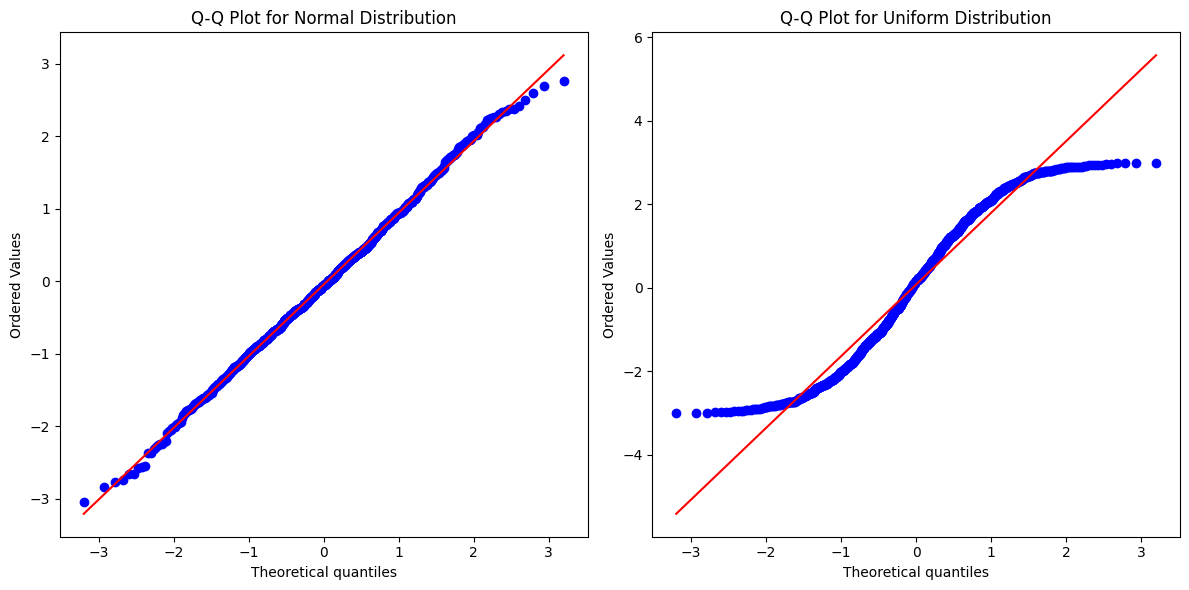

'\n結果の解説\n左側のプロット（正規分布に従うデータ）：\nプロット上の点がほぼ直線的に並んでいます。これは、データが理論的な正規分布に従っていることを示しています。\n右側のプロット（一様分布に従うデータ）：\nプロット上の点が直線から大きく外れています。これは、データが正規分布に従っていないことを示しています。このデータは一様分布に従っているため、Q-Qプロットでは直線的な関係が崩れることになります。\n\nデータに外れ値が1つでもあると直線ではなくなってしまう可能性があります。\n'

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 正規分布に従うランダムデータ
np.random.seed(0)
normal_data = np.random.normal(loc=0, scale=1, size=1000)

# 一様分布に従うランダムデータ（正規分布ではない）
uniform_data = np.random.uniform(low=-3, high=3, size=1000)

# Q-Qプロットを描く
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 正規分布に従うデータのQ-Qプロット
stats.probplot(normal_data, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot for Normal Distribution')

# 一様分布に従うデータのQ-Qプロット
stats.probplot(uniform_data, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot for Uniform Distribution')

plt.tight_layout()
plt.show()

"""
結果の解説
左側のプロット（正規分布に従うデータ）：
プロット上の点がほぼ直線的に並んでいます。これは、データが理論的な正規分布に従っていることを示しています。
右側のプロット（一様分布に従うデータ）：
プロット上の点が直線から大きく外れています。これは、データが正規分布に従っていないことを示しています。このデータは一様分布に従っているため、Q-Qプロットでは直線的な関係が崩れることになります。

データに外れ値が1つでもあると直線ではなくなってしまう可能性があります。
"""

##### シャピロウィルク検定
- シャピロ-ウィルク検定はQ-Qプロットにおいて，どれくらい直線からずれているかを検定する
- 特に母集団が正規分布に従っているかどうかを検定する
    - 多くの検定は正規分布に従っていることを仮定している
- 標本の順序統計量と正規分布の順序統計量の期待値の相関を検定統計量にする
- 検定方法
    - 帰無仮説：母集団が正規分布に従う ← **つまり棄却することを狙っていない**
    - 対立仮説：母集団が正規分布に従わない
    - 「母集団が正規分布に従うという仮説を否定できなかった」という結論に持っていくことにモチベーションがある

In [29]:
male_tipr = df[df['sex'] == 'Male']['tip_rate']
female_tipr = df[df['sex'] == 'Female']['tip_rate']

# 男性のチップ率が正規分布に従っているかを検定
result = stats.shapiro(male_tipr)
"""
• stats.shapiro(x)
- データxに正規性があるかを検定する
- 第一戻り値は検定統計値
- 第二戻り値はp値
"""
print(f"検定統計量：{result.statistic}")
print(f"p値：{result.pvalue}")
print("--------------------------------")
print(f"外れ値除外後")
result = stats.shapiro(np.sort(male_tipr)[:-1])
print(f"検定統計量：{result.statistic}")
print(f"p値：{result.pvalue}")

検定統計量：0.744784334553468
p値：3.2242405768357026e-15
--------------------------------
外れ値除外後
検定統計量：0.9931073588892674
p値：0.6645123250856151


##### F検定
- 2群の等分散性の検定を行う
- 検定統計量には分散の比率を用いる
    - 標本は標本分布に従って抽出されると考えると、標本の分散は確率変数であり、分散の比率も確率変数になる
- 母集団は正規分布に従うことを仮定
- 検定方法
    - 帰無仮説：分散に差はない
    - 対立仮説：分散に差はある

![F分布](image/F分布.jpg)

In [32]:
# F値を計算し、検定を行う
print(f"男性のチップ率の不偏分散：{stats.tvar(male_tipr)}")
print(f"女性のチップ率の不偏分散：{stats.tvar(female_tipr)}")
f = stats.tvar(male_tipr) / stats.tvar(female_tipr) # 通常は大きい方を分子に置く
print(f"F値 : {f}")
p_value = stats.f(dfn = len(male_tipr)-1, dfd = len(female_tipr)-1).sf(f)
print(f"p値：{p_value}")

男性のチップ率の不偏分散：0.004196172792769981
女性のチップ率の不偏分散：0.002876362058404039
F値 : 1.4588472200534603
p値：0.027100863454374458


#### 対応ありのT検定

In [33]:
blood_df = pd.read_csv('/work/MLnote/statistics/dataset/blood_pressure.csv')
blood_df.head()

,patient,sex,agegrp,bp_before,bp_after
0,1,Male,30-45,143,153
1,2,Male,30-45,163,170
2,3,Male,30-45,153,168
3,4,Male,30-45,153,142
4,5,Male,30-45,146,141


In [37]:
print(f"施術前：{blood_df['bp_before'].mean()}")
print(f"施術後：{blood_df['bp_after'].mean()}")
# 血圧の施術前後の差を検定
result = stats.ttest_rel(blood_df['bp_before'], blood_df['bp_after'], alternative='greater') # 血圧は下がってほしいことを期待しているので、前-後>0となるのでgreaterを指定する
print(f"t値：{result.statistic}")
print(f"p値：{result.pvalue}")

施術前：156.45
施術後：151.35833333333332
t値：3.3371870510833657
p値：0.0005648957322420411


## 検定力分析

### 検定力

![検定力](image/検定力.jpg)

- 検定力の構成要素
    - 有意水準
        - 基本的に有意水準は0.05か0.01で行う。検定力を上げるために有意水準を操作するのはNG。
    - サンプルサイズ
        - サンプルサイズを大きくすると検定力も高まる
        - サンプルを増やすと標本平均は母集団の平均に近づいていき、標本の分散も小さくなるので、より尖った分布になる → 帰無分布と対立分布に差ができるので検定力が高まる
        - **サンプルサイズが大きすぎると少しの差でも有意差が出てしまうので、本来やりたかった検定の目的とは外れてしまう**
    - 帰無分布と対立分布の差（効果量）
        - 検出したい差が大きければ大きいほど検定力は高くなる

![サンプルサイズの問題](image/検定力_サンプルサイズ.jpg)

![検定力の構成図](image/検定力の構成図.jpg)

### 検定力分析

#### 効果量の計算
- 効果量とは検定で明らかにしたい2群の差の量
    - 標準偏差はどれくらい離れているのかで測る
- 使用場面例
    - メール配信施策において、何らかの最適化施策を実施し、その施策の実施前と後でどれだけ施策の効果があったかを検定する時。

In [38]:
def cohen_d(x1, x2):
    n1 = len(x1)
    n2 = len(x2)
    dof = n1+n2-2
    std = np.sqrt(((n1-1)*stats.tvar(x1)+(n2-1)*stats.tvar(x2))/dof)
    x1_mean = np.mean(x1)
    x2_mean = np.mean(x2)
    return np.abs((x1_mean - x2_mean))/std

In [39]:
male_tip_rate = df[df['sex'] == 'Male']['tip_rate']
female_tip_rate = df[df['sex'] == 'Female']['tip_rate']
cohen_d(male_tip_rate, female_tip_rate)

np.float64(0.14480153987269387)

In [42]:
"""
有意水準，効果量，検定力，サンプルサイズを残りの値から算出する
• statsmodels.stats.power.TTestIndPowerクラス
• power = TTestIndPower()でインスタンス化
• .solve_power(effect_size, nobs1, alpha, power, ratio, alternative)
• eﬀect_size: 効果量 (cohen’s d)
• nobs1: 標本1のサイズ
• alpha: 有意水準 (ex. 0.05)
• power: 検定力
• ratio: 標本1に対する標本2の大きさ
• alternative: ‘two-sided’, ‘smaller’, ‘larger’
• 算出したいパラメータをNoneにする 
"""

# インスタンスを作成
power = TTestIndPower()
effect_size = cohen_d(male_tip_rate, female_tip_rate)
n1 = len(male_tip_rate)
n2 = len(female_tip_rate)
stats_power = power.solve_power(effect_size = effect_size, nobs1 = n1, alpha = 0.05, power = None, ratio = n2/n1)
print(f"検定力：{stats_power}")

検定力：0.19038260700802495


In [43]:
# 検定力は0.8を目指す
# 有意水準0.05、検定力0.8の時に必要なサンプルサイズ
male_size = power.solve_power(effect_size = effect_size, nobs1 = None, alpha = 0.05, power = 0.8, ratio = 1)
print(male_size)

749.6312654614109


- もし手元にデータがない場合は、今までの経験やドメイン知識から効果量を仮定する
- サンプル比率も同様

In [44]:
power.solve_power(effect_size = 0.2, nobs1 = None, alpha = 0.05, power = 0.8, ratio = 1) # ratio=1は比率が同じくらい

393.4056989990335

#### 検定力の推移

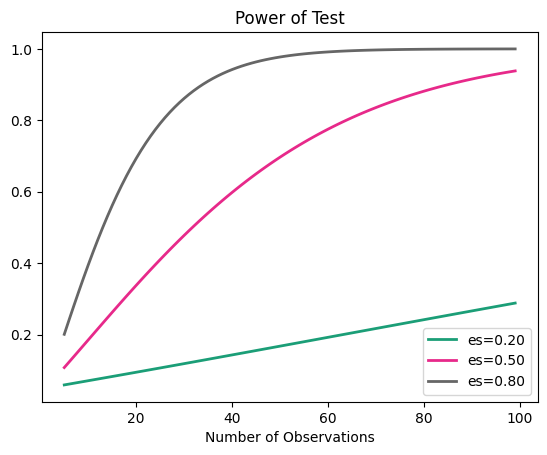

In [48]:
fig = power.plot_power(dep_var = 'nobs', nobs = np.array(range(5, 100)), effect_size = [0.2, 0.5, 0.8], alpha = 0.05)

## データ間の関係性について

### カイ二乗検定(連関の検定)
**2つのカテゴリ変数間に相関関係があるかどうかを検定**  
• 帰無仮説には「連関がない(=独立)」  
• 対立仮説には「連関がある(=独立ではない)」

![カイ二乗分布](image/カイ二乗分布.jpg)

In [12]:
# 全データを母集団としたときに、2つのサンプルを取得し、2つのグループのディナーの比率の差を検定
n = 100
sampled_df_1 = df.sample(n)
sampled_df_2 = df.sample(n)

# Dinnerの比率
dinner_count_1 = len(sampled_df_1[sampled_df_1['time'] == 'Dinner'])
dinner_count_2 = len(sampled_df_2[sampled_df_2['time'] == 'Dinner'])

# カイ2乗検定
chi2, p, dof, ex = stats.chi2_contingency([[dinner_count_1, n - dinner_count_1], [dinner_count_2, n - dinner_count_2]], correction = False)
"""
chi2, p, dof, ex = stats.chi2_conRngency(obs, correcRon=False)
- obs: 観測度数
- correc9on: イェイツの修正(通常はFalseでOK)
※イェイツの修正とは、通常のカイ二乗検定よりp値を高く出やすくしたもの（有意差が出やすいのではないかという主張があった）
"""
print("カイ2乗検定")
print(f"カイ2乗値：{chi2}, p値：{p}")
if p_value <= 0.05:
    print("対立仮説を採用")
else:
    print("帰無仮説を否定できなかった")

カイ2乗検定
カイ2乗値：0.2761159687068569, p値：0.5992583230406663
帰無仮説を否定できなかった


### クラメールの連関係数

![クラメールの連関係数](image/クラメールの連関係数.jpg)

### アソシエーション分析（association analysis）
**ある事象とある事象の共起性や関係性などの法則を見つける分析手法。**  
例) 商品の購入データを元に「xを買った人はyも買っている」などの法則を見つける  
##### 取り組み方
1. 共起性を調べたいのか、x→yのような関係性を調べたいのかという部分を定める
2. 共起性であれば共起性を示す指標を一通り出す。関係性であれば、事象同士の関係性を示す指標を一通り出す。
3. 複数の指標を複合的に見ることで、法則性や因果関係などの解釈を行う。
    - 指標によって結果が違う場合がある。これはどちらかの指標が誤りということではなく、それぞれ別の視点からの解釈を与えてくれるものである。  
        - confidenceは大きいがliftはほぼ1である時、これはxの購入の有無に左右されることなくyを購入する人が多い。
        - liftが大きくconfidenceが小さい時、全体のyの購入の割合はconfidenceをliftで割って計算できるので、yの購買件数が少ないことが分かる。つまり商品xは商品yを買ってもらうために非常に重要な商品である可能性が分かる。

#### 類似度・関連性指標まとめ

| 指標名 | 定義 | 特徴 | 値の範囲 |
|--------|------|------|----------|
| **Jaccard係数** | $\frac{\left| X \cap Y \right|}{\left| X \cup Y \right|}$ | 0の場合は同時が無いことを表し、1に近づくについて同時が多いことを表す | $[0,1]$ |
| **Dice係数** | $\frac{2 \left| X \cap Y \right|}{\left| X \right| + \left| Y \right|}$ | 0の場合は同時が無いことを表し、1に近づくについて同時が多いことを表す | $[0,1]$ |
| **Cosine類似度** | $\frac{\left| X \cap Y \right|}{\sqrt{\left| X \right| + \left| Y \right|}}$ | 0の場合は同時が無いことを表し、1に近づくについて同時が多いことを表す | $[0,1]$ | 
| **Simpson係数** | $\frac{\left| X \cap Y \right|}{\min(\left| X \right|, \left| Y \right|)}$ | 0の場合は同時が無いことを表し、1に近づくについて同時が多いことを表す | $[0,1]$ | 
| **Leverage** | $P(X \cap Y) - P(X) P(Y)$ | XとYの独立性に関する指標。0であれば独立、正であれば同時、負であれば同時にされない。 | $[\frac{-1}{4},\frac{1}{4}]$ | 
| **Confidence** | $Confidence(X \to Y) = \frac{\left| X \cap Y \right|}{\left| X \right|}$ | Xをした人の中でYをした人の割合。 | $[0,1]$ | 
| **Lift** | $Lift(X \to Y) = \frac{\frac{\left| X \cap Y \right|}{\left| X \right|}}{\frac{\left| Y \right|}{\left| U \right|}}$ | XをしたことによってYをする確率が何倍になるかを表した指標。 | $[0, \infty)$ |
| **Conviction** | $Conviction(X \to Y) = \frac{1-\frac{\left| Y \right|}{\left| U \right|}}{1-\frac{\left| X \cap Y \right|}{\left| X \right|}}$ | XをしたことによってYをしない確率が何倍になるかを表した指標。 | $[1, \infty)$ |



#### 実装

In [39]:
# Confidenceの計算
def confidence(x, y):
    """
    Confidence(X -> Y) = P(Y | X) = |X ∩ Y| / |X|
    
    - x, y: リストまたは Pandas Series（0/1 の値を想定）
    - 戻り値: Confidence スコア（0〜1）
    """
    x, y = np.asarray(x), np.asarray(y)  # NumPy 配列に変換
    x_inter_y = np.logical_and(x, y).sum()  # |X ∩ Y| を計算
    x_count = np.sum(x)  # |X| を計算
    return x_inter_y / x_count if x_count > 0 else 0

# Liftの計算
def lift(x, y):
    """
    Lift(X -> Y) = (|X ∩ Y| / |X|) / (|Y| / |U|)
    xをするとyをする確率が何倍になるか = (xをしてyをする確率)/(yをする確率)
    
    - x, y: リストまたは Pandas Series（0/1 の値を想定）
    - 戻り値: Lift スコア（0以上の実数）
    """
    if len(x) != len(y):
        raise ValueError("x と y は同じ長さである必要があります")

    x, y = np.asarray(x), np.asarray(y)  # NumPy 配列に変換
    x_inter_y = np.logical_and(x, y).sum()  # |X ∩ Y| を計算
    x_count = np.sum(x)  # |X| を計算
    y_prob = np.sum(y) / len(y)  # P(Y) = |Y| / |U|

    if x_count == 0 or y_prob == 0:  # ゼロ除算の防止
        return 0

    return (x_inter_y / x_count) / y_prob

# Convictionの計算
def conviction(x, y):
    """
    Conviction(X -> Y) = (1 - P(Y)) / (1 - P(X ∩ Y | X))
    XをするとYをしない確率が何分の一か =  (Yをしない確率)/(XはしたけどYはしない確率)

    - x, y: リストまたは Pandas Series（0/1 の値を想定）
    - 戻り値: Conviction スコア（1以上の実数）
    """
    if len(x) != len(y):
        raise ValueError("x と y は同じ長さである必要があります")

    x, y = np.asarray(x), np.asarray(y)  # NumPy 配列に変換
    x_inter_y = np.logical_and(x, y).sum()  # |X ∩ Y| を計算
    x_count = np.sum(x)  # |X| を計算
    y_prob = np.sum(y) / len(y)  # P(Y) = |Y| / |U|

    if x_count == 0 or y_prob == 1:  # ゼロ除算の防止
        return float("inf")

    conf = x_inter_y / x_count if x_count > 0 else 0  # Confidence(X → Y)
    return (1 - y_prob) / (1 - conf) if conf < 1 else float("inf")

### 数量化理論

#### 数量化Ⅱ類
- 説明変数も被説明変数もカテゴリ変数のとき、説明変数と被説明変数の関係について分析する手法
    - カテゴリ変数をベクトル化する
    - 被説明変数の同じカテゴリのデータは近く、別のカテゴリのデータは遠くしたい（カテゴリ内の分散は小さく、カテゴリ間の分散は大きく）

In [53]:
def quantification_ii_1(df, target_col, feature_cols):
    """
    数量化Ⅱ類を実行する関数
    
    Parameters:
    df (pd.DataFrame): 入力データ
    target_col (str): 目的変数（カテゴリ変数）
    feature_cols (list): 特徴量（カテゴリ変数のみ）
    
    Returns:
    pd.DataFrame: 各データの y 値を追加したデータフレーム
    np.array: 変数ごとの数量化ベクトル
    pd.DataFrame: 固有ベクトルと各変数の関係を示すデータフレーム
    """
    # カテゴリカル変数をダミー変換
    X = pd.get_dummies(df[[target_col] + feature_cols])
    target_dummies = [col for col in X.columns if col.startswith(target_col + "_")]
    dependent_vars = [col for col in X.columns if col not in target_dummies]

    # 共分散行列の計算
    S_tot = X[dependent_vars].cov(ddof=0)
    
    # 各クラスのデータ数
    class_counts = {cls: X[f'{target_col}_{cls}'].sum() for cls in df[target_col].unique()}
    
    # 各クラスの共分散行列
    S_class = {cls: X[X[f'{target_col}_{cls}'] == 1][dependent_vars].cov(ddof=0) for cls in df[target_col].unique()}
    
    # 群内共分散行列と群間共分散行列
    N_total = sum(class_counts.values())
    S_within = sum(class_counts[cls] * S_class[cls] for cls in class_counts) / N_total
    S_between = S_tot - S_within # 群間分散 = 全分散 - 郡内分散
    
    # 固有値・固有ベクトルの計算
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))
    
    # 最大の固有値を持つインデックス
    idx_eta_square = np.argmax(eig_vals)
    qualitization_vector = eig_vecs[:, idx_eta_square]
    
    # 最大の固有値に対応する固有ベクトルと変数名を紐づけ
    eigenvalue_df = pd.DataFrame({
        'variable': dependent_vars,
        'eigenvalue_contribution': qualitization_vector
    }).sort_values(by='eigenvalue_contribution', key=abs, ascending=False)

    # y値の計算
    df_with_y = pd.concat([df[[target_col]], X[dependent_vars]], axis=1)
    df_with_y['y'] = X[dependent_vars].dot(qualitization_vector)
    
    # 符号調整
    y_means = df_with_y.groupby(target_col, observed=False)['y'].mean()
    if y_means.iloc[0] < y_means.iloc[-1]:
        qualitization_vector = -1 * qualitization_vector
        df_with_y['y'] = - df_with_y['y']
        eigenvalue_df['eigenvalue_contribution'] = -eigenvalue_df['eigenvalue_contribution']

    # 分布をプロット
    for cls in df[target_col].unique():
        plt.hist(df_with_y[df_with_y[target_col] == cls]['y'], alpha=0.3, label=cls)
    
    plt.legend()
    plt.show()
    
    return df_with_y, qualitization_vector, eigenvalue_df

In [54]:
def convert_int_to_category(df, columns=None):
    """
    整数型（int）のカラムをカテゴリ型に変換する
    
    Parameters:
    df (pd.DataFrame): 変換対象のデータフレーム
    columns (list, optional): 変換するカラムのリスト（指定しない場合は int 型のカラムを自動検出）
    
    Returns:
    pd.DataFrame: 指定したカラムをカテゴリ型に変換したデータフレーム
    """
    df = df.copy()
    
    # 変換対象のカラムを特定
    if columns is None:
        columns = df.select_dtypes(include=['int']).columns.tolist()
    
    # カラムをカテゴリ型に変換
    for col in columns:
        df[col] = df[col].astype('category')
    
    return df

In [55]:
def quantification_ii_2(df, target_col, feature_cols):
    # カテゴリカル変数をダミー変換
    X = pd.get_dummies(df[[target_col] + feature_cols])
    target_dummies = [col for col in X.columns if col.startswith(target_col + "_")]
    dependent_vars = [col for col in X.columns if col not in target_dummies]
    
    # 共分散行列の計算
    S_tot = X[dependent_vars].cov(ddof=0)
    
    # 各クラスのデータ数
    class_counts = {cls: X[f'{target_col}_{cls}'].sum() for cls in df[target_col].unique()}
    
    # 各クラスの共分散行列
    S_class = {cls: X[X[f'{target_col}_{cls}'] == 1][dependent_vars].cov(ddof=0) for cls in df[target_col].unique()}
    
    # 群内共分散行列と群間共分散行列
    N_total = sum(class_counts.values())
    S_within = sum(class_counts[cls] * S_class[cls] for cls in class_counts) / N_total
    S_between = S_tot - S_within
    
    # 固有値・固有ベクトルの計算
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_tot).dot(S_between))
    argsort_ev = np.argsort(eig_vals)
    
    # 第1主成分（y1）
    idx_eta_square_1 = argsort_ev[-1]
    qualitization_vector_1 = eig_vecs[:, idx_eta_square_1]
    df_with_y = pd.concat([df[[target_col]], X[dependent_vars]], axis=1)
    df_with_y['y1'] = X[dependent_vars].dot(qualitization_vector_1)
    
    # 第2主成分（y2）
    idx_eta_square_2 = argsort_ev[-2]
    qualitization_vector_2 = eig_vecs[:, idx_eta_square_2]
    df_with_y['y2'] = X[dependent_vars].dot(qualitization_vector_2)
    
    # 符号調整
    y1_means = df_with_y.groupby(target_col, observed=False)['y1'].mean()
    if y1_means.iloc[0] < y1_means.iloc[-1]:
        qualitization_vector_1 *= -1
        df_with_y['y1'] *= -1
    
    y2_means = df_with_y.groupby(target_col, observed=False)['y2'].mean()
    if y2_means.iloc[0] < y2_means.iloc[-1]:
        qualitization_vector_2 *= -1
        df_with_y['y2'] *= -1
    
    # 固有値と変数名の対応
    eigen_info = pd.DataFrame({
        'Variable': dependent_vars,
        'EigenVector_1': qualitization_vector_1,
        'EigenVector_2': qualitization_vector_2
    })
    
    # 分布をプロット
    plt.figure(figsize=(8, 6))
    markers = ['o', '^', 's', 'x', 'D']
    for idx, cls in enumerate(df[target_col].unique()):
        data = df_with_y[df_with_y[target_col] == cls]
        plt.scatter(data['y1'], data['y2'], label=cls, alpha=0.5, marker=markers[idx % len(markers)])
    
    plt.xlabel('y1 (First Discriminant Axis)')
    plt.ylabel('y2 (Second Discriminant Axis)')
    plt.legend()
    plt.grid()
    plt.show()
    
    return df_with_y, eigen_info, qualitization_vector_1, qualitization_vector_2


In [56]:
def quantification_ii_3(df, target_col, feature_cols, qual1, qual2):
    """
    数量化Ⅱ類の結果を自動で可視化する関数
    
    Args:
        df: データフレーム
        target_col: 目的変数のカラム名
        feature_cols: 説明変数（カテゴリ変数）のカラム名リスト
        qual1: 1つ目の判別軸の数量化ベクトル
        qual2: 2つ目の判別軸の数量化ベクトル
    
    Returns:
        None (プロットを表示)
    """
    
    # 1. カテゴリーリスト & 各カテゴリの要素数を自動取得
    category_groups = []
    categories = []
    
    for col in feature_cols:
        unique_values = df[col].unique()
        category_groups.append(len(unique_values))
        categories.extend([f"{col}_{val}" for val in unique_values])

    def centerize_qualitization(qual, category_groups):
        """ 各カテゴリのスコアを中心化 """
        start = 0
        centered_qual = []
        for size in category_groups:
            group = np.concatenate([qual[start:start + size], [0]])
            group = group - group.mean()
            centered_qual.append(group[:-1])
            start += size
        return np.concatenate(centered_qual)

    # 2. 中心化
    y1 = centerize_qualitization(qual1, category_groups)
    y2 = centerize_qualitization(qual2, category_groups)

    # 3. データフレーム作成
    df_qualitization = pd.DataFrame({'category': categories, 'y1': y1, 'y2': y2})

    # 4. 可視化
    plt.figure(figsize=(8, 6))
    plt.scatter(df_qualitization['y1'], df_qualitization['y2'], s=100)

    texts = [
        plt.text(df_qualitization['y1'][i], df_qualitization['y2'][i], df_qualitization['category'][i], 
                 fontsize=14, ha='center', va='center') 
        for i in range(len(df_qualitization))
    ]

    adjust_text(texts)
    plt.xlabel("First Discriminant Axis (y1)")
    plt.ylabel("Second Discriminant Axis (y2)")
    plt.title("Visualization of Quantification II Categories")
    plt.show()

##### 例) タイタニック

In [57]:
df = pd.read_csv("dataset/titanic/train.csv")
df = df.dropna() # 今回欠損値は削除する
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  183 non-null    int64  
 1   Survived     183 non-null    int64  
 2   Pclass       183 non-null    int64  
 3   Name         183 non-null    object 
 4   Sex          183 non-null    object 
 5   Age          183 non-null    float64
 6   SibSp        183 non-null    int64  
 7   Parch        183 non-null    int64  
 8   Ticket       183 non-null    object 
 9   Fare         183 non-null    float64
 10  Cabin        183 non-null    object 
 11  Embarked     183 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


In [59]:
df = convert_int_to_category(df, columns = ["Survived", "Pclass", "SibSp", "Parch"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  183 non-null    int64   
 1   Survived     183 non-null    category
 2   Pclass       183 non-null    category
 3   Name         183 non-null    object  
 4   Sex          183 non-null    object  
 5   Age          183 non-null    float64 
 6   SibSp        183 non-null    category
 7   Parch        183 non-null    category
 8   Ticket       183 non-null    object  
 9   Fare         183 non-null    float64 
 10  Cabin        183 non-null    object  
 11  Embarked     183 non-null    object  
dtypes: category(4), float64(2), int64(1), object(5)
memory usage: 14.2+ KB


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/numpy/lib/_histograms_impl.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


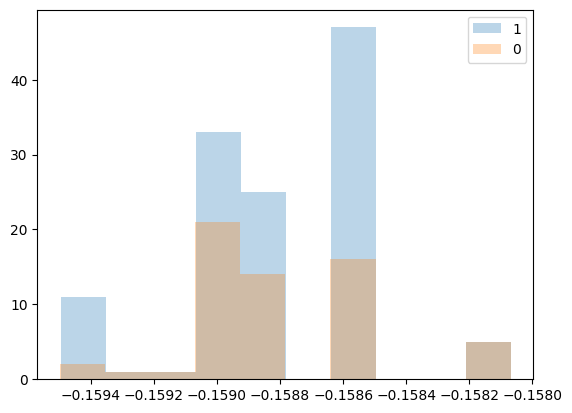

In [60]:
feature_cols = ["Pclass", 'SibSp', 'Parch', 'Sex', 'Embarked']
target_col = "Survived"
df_with_y, qualitization_vector, eigenvalue_df = quantification_ii_1(df, target_col, feature_cols)

- 0と1でうまくわけられていない

In [30]:
# 固有ベクトル
eigenvalue_df

,variable,eigenvalue_contribution
14,Embarked_Q,-0.512781-0.000000j
15,Embarked_S,-0.512428-0.000000j
13,Embarked_C,-0.512108-0.000000j
2,Pclass_3,0.260661-0.000000j
0,Pclass_1,0.259838-0.000000j
1,Pclass_2,0.259282-0.000000j
12,Sex_male,0.060437-0.000000j
11,Sex_female,0.060436-0.000000j
10,Parch_4,0.018058-0.000000j
8,Parch_1,0.018047-0.000000j


In [33]:
qualitization_vector

array([ 0.25983758-0.j,  0.2592819 -0.j,  0.26066084-0.j,  0.01517273-0.j,
        0.01521564-0.j,  0.01518219-0.j,  0.0152252 -0.j,  0.01804239-0.j,
        0.01804721-0.j,  0.01803905-0.j,  0.01805771-0.j,  0.06043592-0.j,
        0.06043659-0.j, -0.51210799+0.j, -0.51278084+0.j, -0.51242818+0.j])

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


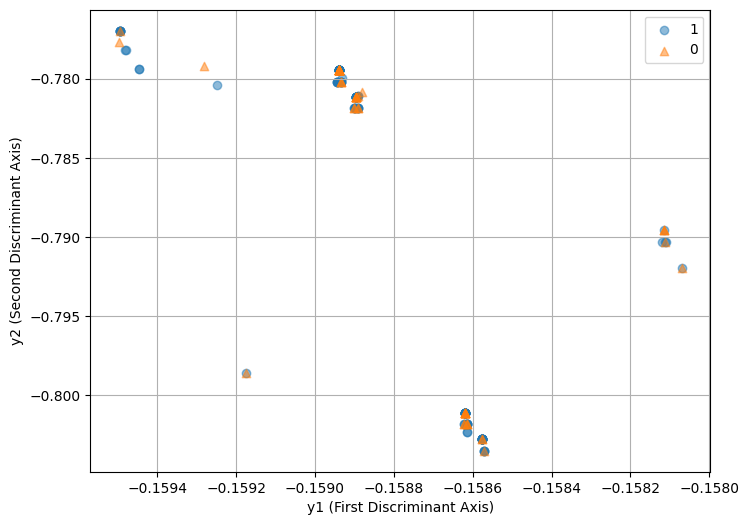

In [35]:
df_with_y, eigen_info, qualitization_vector_1, qualitization_vector_2 = quantification_ii_2(df, target_col, feature_cols)

In [36]:
eigen_info

,Variable,EigenVector_1,EigenVector_2
0,Pclass_1,0.259838-0.000000j,-0.066798+0.000000j
1,Pclass_2,0.259282-0.000000j,-0.064304+0.000000j
2,Pclass_3,0.260661-0.000000j,-0.076891+0.000000j
3,SibSp_0,0.015173-0.000000j,-0.269075+0.000000j
4,SibSp_1,0.015216-0.000000j,-0.270757+0.000000j
5,SibSp_2,0.015182-0.000000j,-0.269541+0.000000j
6,SibSp_3,0.015225-0.000000j,-0.270002+0.000000j
7,Parch_0,0.018042-0.000000j,-0.188954+0.000000j
8,Parch_1,0.018047-0.000000j,-0.189674+0.000000j
9,Parch_2,0.018039-0.000000j,-0.189679+0.000000j


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:763: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:906: ComplexWarning: Casting complex values to 

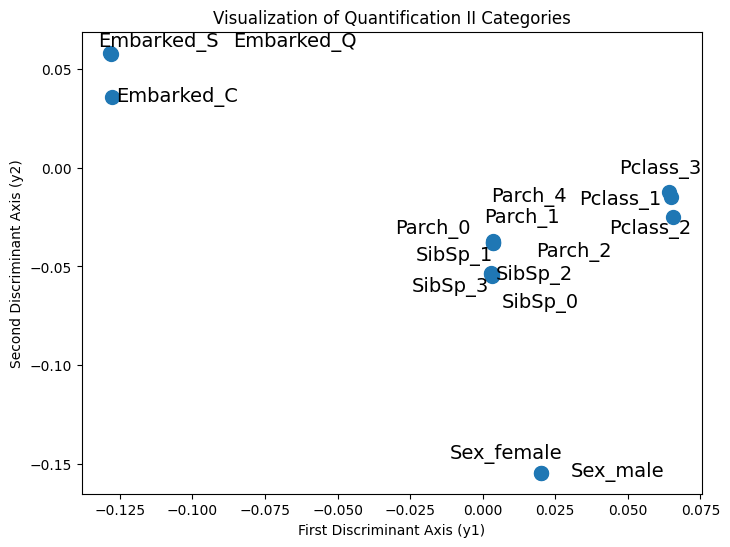

In [37]:
quantification_ii_3(df, target_col, feature_cols, qualitization_vector_1, qualitization_vector_2)

#### 数量化Ⅲ類
- アンケートデータで主に使われる
- 現状、アンケートデータを使用することは無いので一旦スキップする

#### 数量化Ⅳ類
- 距離や相関、共通する属性データの数などの類似度を示すデータを2次元に可視化する手法
- 類似度の高いものは近く、類似度の低いものは遠くになっている場合、固有ベクトルはうまく類似度を反映できていると言える。
    - 次元削減にも使える

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

def quantification_type_iv(df_scores, labels=None):
    """
    数量化Ⅳ類を適用し、データを2次元に可視化する
    
    Parameters:
    df_scores (pd.DataFrame): 相関行列を求めるデータフレーム
    labels (dict, optional): カラム名をマッピングする辞書（例: {'数学': 'Math', '英語': 'English'}）
    
    Returns:
    pd.DataFrame: 2次元に変換したデータフレーム
    """
    
    # 相関行列を計算
    df_corr = df_scores.corr()

    # 行列の作成
    nda_diag = - np.diag((df_corr.sum(axis=0).values - 1) + (df_corr.sum(axis=1).values - 1))
    nda_non_diag_pre = (df_corr + df_corr.T).values
    nda_non_diag = nda_non_diag_pre - np.diag(np.diag(nda_non_diag_pre))
    nda_matrix = nda_diag + nda_non_diag

    # 固有値・固有ベクトルの計算
    eig_val, eig_vec = np.linalg.eig(nda_matrix)

    # 固有値の降順ソート
    argsort = np.argsort(-eig_val)
    qualification_vector_1 = eig_vec[:, argsort[1]] # 一番大きい固有値に対応する固有ベクトル
    qualification_vector_2 = eig_vec[:, argsort[2]] # 二番目に大きい固有値に対応する固有ベクトル

    # 結果をデータフレーム化
    df_qualification = pd.DataFrame({'qv_1': qualification_vector_1, 'qv_2': qualification_vector_2}, index=df_scores.columns)

    # 可視化
    plt.figure(figsize=(10, 7))
    plt.scatter(df_qualification['qv_1'], df_qualification['qv_2'], s=100)

    # ラベルを追加
    texts = []
    for i in range(len(df_qualification)):
        label = df_qualification.index[i]
        if labels and label in labels:
            label = labels[label]
        texts.append(plt.text(df_qualification['qv_1'][i], df_qualification['qv_2'][i], label, fontsize=18, ha='center', va='center'))
    
    adjust_text(texts)

    # 補助線
    plt.axhline(y=0, color='gray', alpha=0.5, linewidth=1, linestyle='--')
    plt.axvline(x=0, color='gray', alpha=0.5, linewidth=1, linestyle='--')

    plt.title("Quantification Type IV Visualization")
    plt.show()

    return df_qualification


/tmp/ipykernel_2989/2467805729.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(df_qualification['qv_1'][i], df_qualification['qv_2'][i], label, fontsize=18, ha='center', va='center'))


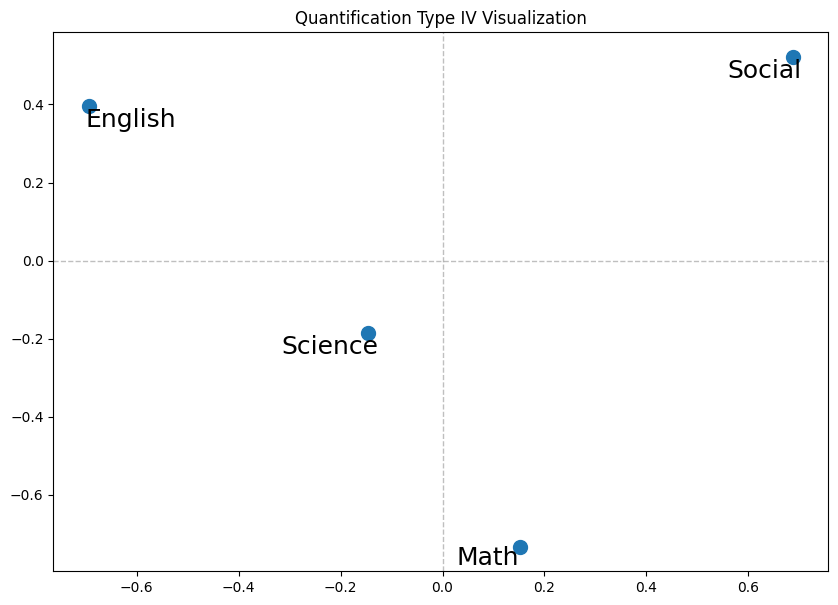

In [64]:
df_scores = pd.DataFrame({  
    '数学': [80, 75, 90, 85, 70],  
    '英語': [65, 60, 80, 70, 75],  
    '理科': [85, 80, 95, 90, 85],  
    '社会': [60, 70, 75, 80, 65]
})

# 日本語の科目名を英語に変換（オプション）
mapper_ja2en = {'数学': 'Math', '英語': 'English', '理科': 'Science', '社会': 'Social'}

df_qualification = quantification_type_iv(df_scores, labels=mapper_ja2en)


### 回帰分析

In [1]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def run_regression(df, target_col, feature_cols):
    """
    汎用的な重回帰分析関数
    - df: データフレーム
    - target_col: 目的変数（数値型）
    - feature_cols: 説明変数（数値 or カテゴリ変数）
    """
    # データのコピー
    data = df.copy()

    # 説明変数のダミー変数化（カテゴリ変数を含む場合）
    data = pd.get_dummies(data, columns=[col for col in feature_cols if data[col].dtype == "object"], drop_first=True)

    # 目的変数と説明変数を取得
    y = data[target_col]
    X = data[feature_cols]

    # 欠損値処理（平均値で補完）
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())

    # 定数項を追加
    X = sm.add_constant(X)

    # モデルの作成・学習
    model = sm.OLS(y, X).fit()

    # 結果の表示
    print(model.summary())

    # VIF（分散拡大係数）の計算
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    print("\n【VIF（多重共線性チェック）】")
    print(vif_data)

    return model


## appendix

### 標本分布

![標本分布](image/標本分布.jpg)

### 確率分布

![確率分布](image/確率分布.jpg)